In [1]:
# used for statistical processes, i.e scaling the dataset

from lstm_models import LSTM
from gpu_dataloader import GPUDataset
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# plotting the data
import matplotlib.pyplot as plt
# used for the dataframes
import pandas as pd

import numpy as np
%matplotlib inline


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: my-god-its-full-of-stars. Use `wandb login --relogin` to force relogin


In [ ]:
import wandb
wandb.init(project='Hardware Utilization Prediction')

In [3]:
dataset = GPUDataset(small_df=True)

In [4]:
dataset.X.shape

torch.Size([1000, 1, 19])

In [5]:
num_epochs: int = 100
learning_rate: float = 0.015

# number of features
input_size: int = dataset.X.shape[2]
# number of features in hidden state
hidden_size: int = dataset.X.shape[2] * 8
# number of stacked lstm layers
num_layers: int = 1
# number of output classes

num_classes: int = dataset.y.shape[1]

In [6]:
wandb.config.num_epochs = num_epochs
wandb.config.learning_rate = learning_rate
wandb.config.input_size = input_size
wandb.config.hidden_size = hidden_size
wandb.config.num_layers = num_layers
wandb.config.num_classes = num_classes

In [7]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, dataset.X.shape[1])
lstm.train()

LSTM(
  (lstm): LSTM(19, 152, batch_first=True)
  (fc_1): Linear(in_features=152, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=128, bias=True)
  (fc_3): Linear(in_features=128, out_features=7, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

In [8]:
# mean squared error for regression
criterion = nn.MSELoss()
# optimizer function
optimizer = torch.optim.AdamW(lstm.parameters(), lr=learning_rate)

In [9]:
import math

def get_rmse(actual_values, predicted_values) -> float:
    '''returns the root mean squared error'''
    return math.sqrt(mean_squared_error(actual_values, predicted_values))

def get_mape(actual_values, predicted_values):
    '''returns the mean absolue percentage error'''
    return np.mean(np.abs(actual_values - predicted_values) / np.abs(actual_values) * 100)

def get_mae(actual_values, predicted_values) -> float:
    '''returns the mean absolute error'''
    return mean_absolute_error(actual_values, predicted_values)

In [10]:
LOSS: str = 'loss'
RMSE_TRAINING: str = 'root mean squared error (training)'
MAE_TRAINING: str = 'mean absolute error (training)'

wandb.define_metric(LOSS, summary='min')
wandb.define_metric(RMSE_TRAINING, summary='min')
wandb.define_metric(MAE_TRAINING, summary='min')

In [11]:
import random

batch_size: int = 1000

for epoch in range(num_epochs):
    print(f'Epoch: {epoch + 1}')

    sample_idx = [idx for idx in range(len(dataset) // batch_size)]

    while len(sample_idx) > 0:
        choice = random.choice(sample_idx)
        sampler = SubsetRandomSampler(
            list(range(choice*batch_size, (choice+1)*batch_size)))
        train_loader = DataLoader(
            dataset, batch_size=batch_size, shuffle=False, num_workers=5, sampler=sampler)

        for _, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            outputs = lstm.forward(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        sample_idx.remove(choice)
        print(f'removed {choice}, remaining: {len(sample_idx)}')

    # logging to wandb
    o = outputs.detach()
    rmse = get_rmse(o, labels)
    mae = get_mae(o, labels)
    log_dict: dict = {
        LOSS: loss.item(),
        RMSE_TRAINING: rmse,
        MAE_TRAINING: mae,
    }
    wandb.log(log_dict)

    if epoch % 10 == 0:
        print(
            f'Epoch: {epoch + 1}, loss: {loss.item():2f}, rmse: {rmse:2f}, mae: {mae:2f}')


Epoch: 1
removed 0, remaining: 0
Epoch: 1, loss: 0.027593, rmse: 0.166113, mae: 0.095605
Epoch: 2
removed 0, remaining: 0
Epoch: 3
removed 0, remaining: 0
Epoch: 4
removed 0, remaining: 0
Epoch: 5
removed 0, remaining: 0
Epoch: 6
removed 0, remaining: 0
Epoch: 7
removed 0, remaining: 0
Epoch: 8
removed 0, remaining: 0
Epoch: 9
removed 0, remaining: 0
Epoch: 10
removed 0, remaining: 0
Epoch: 11
removed 0, remaining: 0
Epoch: 11, loss: 0.017033, rmse: 0.130511, mae: 0.072429
Epoch: 12
removed 0, remaining: 0
Epoch: 13
removed 0, remaining: 0
Epoch: 14
removed 0, remaining: 0
Epoch: 15
removed 0, remaining: 0
Epoch: 16
removed 0, remaining: 0
Epoch: 17
removed 0, remaining: 0
Epoch: 18
removed 0, remaining: 0
Epoch: 19
removed 0, remaining: 0
Epoch: 20
removed 0, remaining: 0
Epoch: 21
removed 0, remaining: 0
Epoch: 21, loss: 0.015509, rmse: 0.124537, mae: 0.067074
Epoch: 22
removed 0, remaining: 0
Epoch: 23
removed 0, remaining: 0
Epoch: 24
removed 0, remaining: 0
Epoch: 25
removed 0, re

In [44]:
import time

current_time = time.ctime()
current_time

'Wed Sep  7 17:04:23 2022'

In [46]:
# torch.save(lstm.state_dict(), f'models/epochs-{num_epochs}-{current_time}')

In [18]:
lstm.eval()

# forward pass
prediction = lstm(dataset.X)
prediction = prediction.data.numpy()
prediction = dataset.standard_scaler.fit_transform(prediction)

actual_data = dataset.y.data.numpy()
actual_data = dataset.minmax_scaler.fit_transform(actual_data)

# reverse transformation
prediction = dataset.standard_scaler.inverse_transform(prediction)
actual_data = dataset.minmax_scaler.inverse_transform(actual_data)

label_columns = dataset.get_default_label_columns()
# create dataframes
prediction_df = pd.DataFrame(prediction, columns=label_columns)
actual_data_df = pd.DataFrame(actual_data, columns=label_columns)


In [19]:
def plot_column(actual_values=actual_data_df, predicted_values=prediction_df, column_number: int = 0, rmse_threshold: float = 0.30):

    if len(label_columns) <= column_number:
        print('Out of Prediction Bounds')
        return

    plt.figure(figsize=(25, 15))  # plotting

    column = label_columns[column_number]

    rmse = get_rmse(actual_values[column], predicted_values[column])
    mae = mean_absolute_error(actual_values[column], predicted_values[column])

    predicted_color = 'green' if rmse < rmse_threshold else 'orange'

    plt.plot(actual_values[column], label=column, color='black')  # actual plot
    plt.plot(predicted_values[column], label='pred_' +
             column, color=predicted_color)  # predicted plot

    plt.title('Time-Series Prediction')
    plt.plot([], [], ' ', label=f'RMSE: {rmse}')
    plt.plot([], [], ' ', label=f'MAE: {mae}')
    plt.legend()
    plt.show()


## See Predictions on Training Dataset

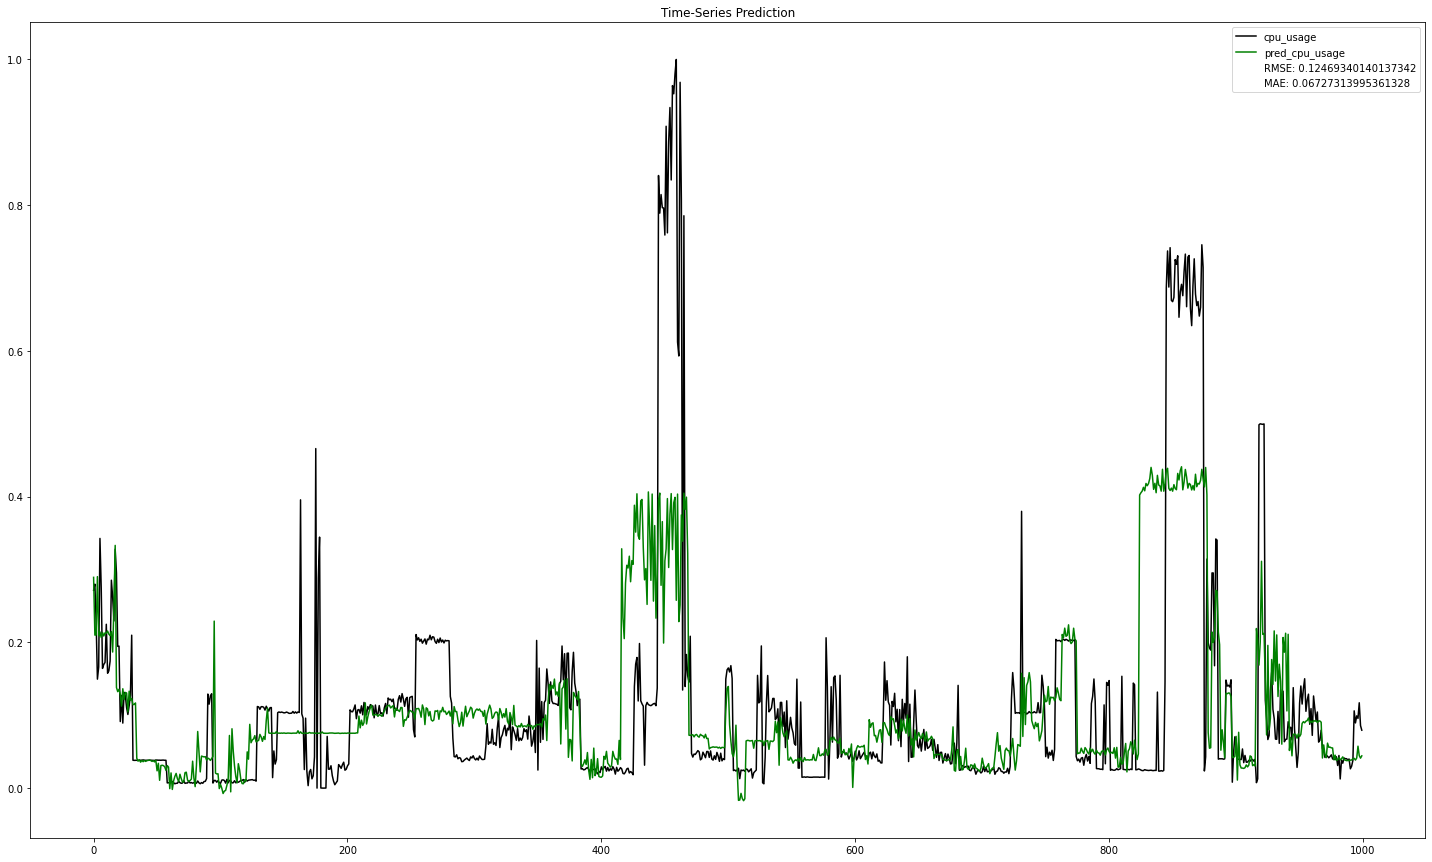

In [27]:
plot_column(column_number=0)

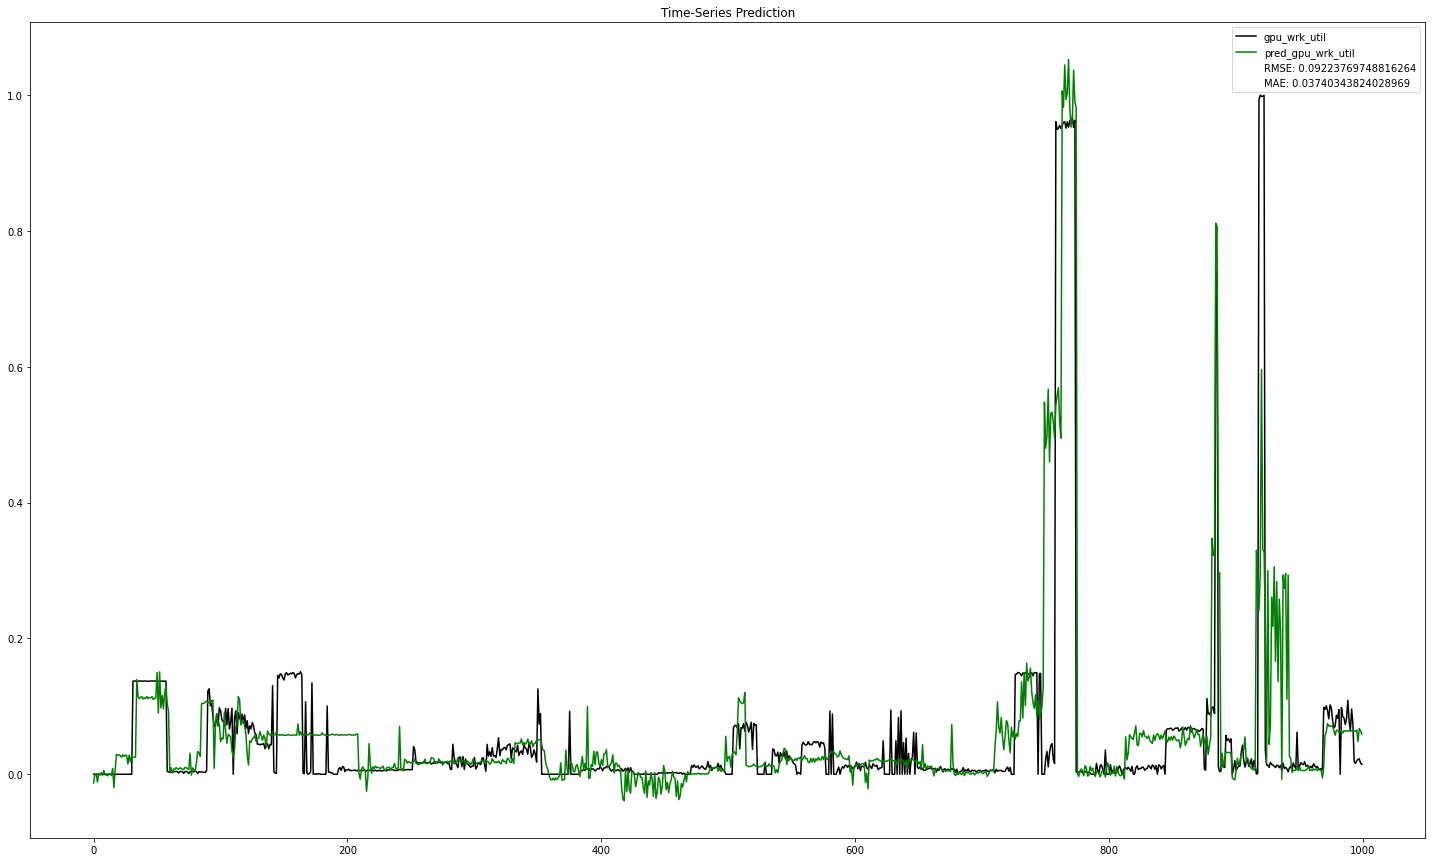

In [28]:
plot_column(column_number=1)

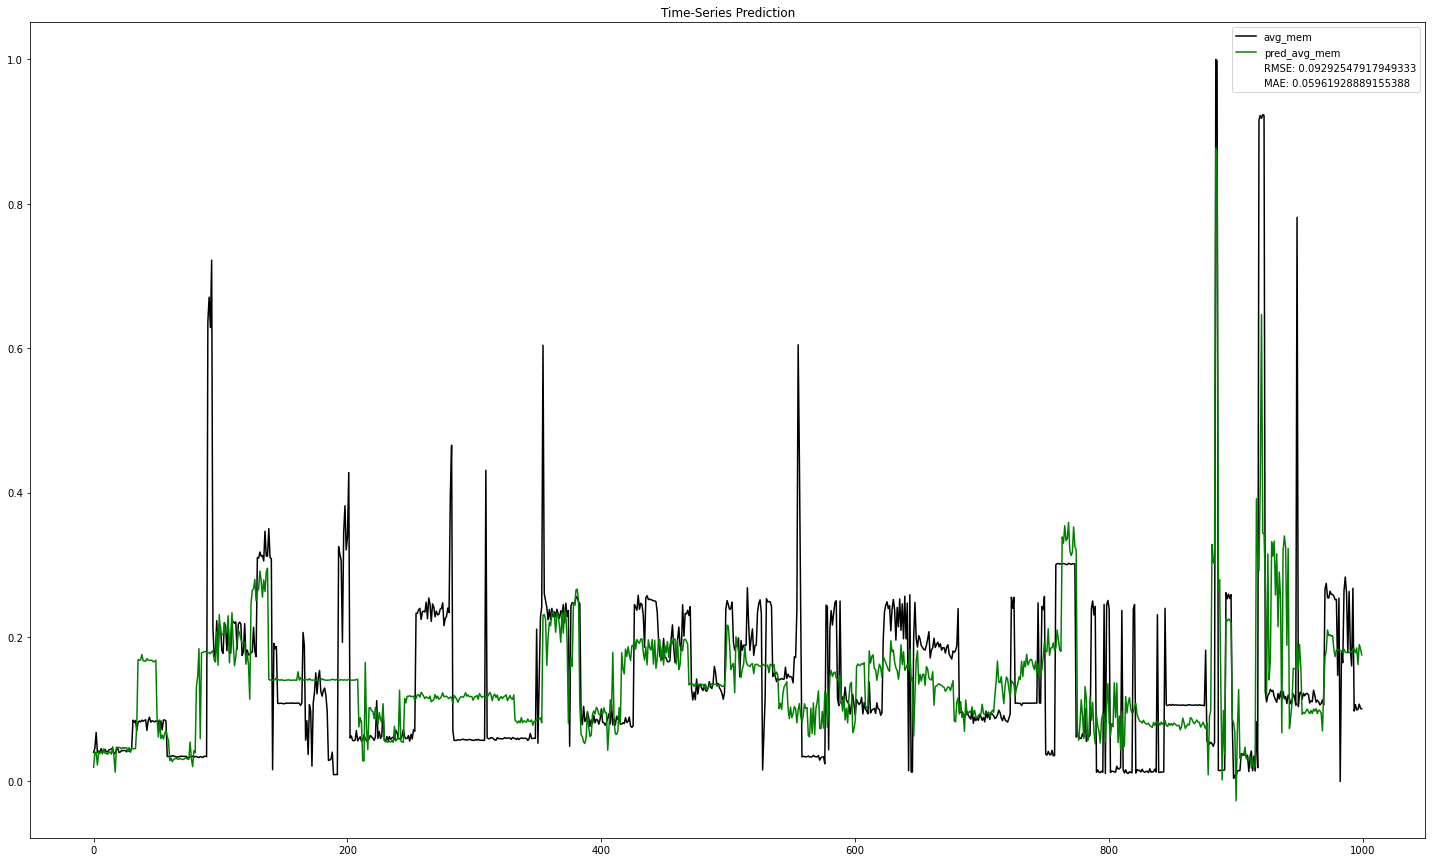

In [29]:
plot_column(column_number=2)

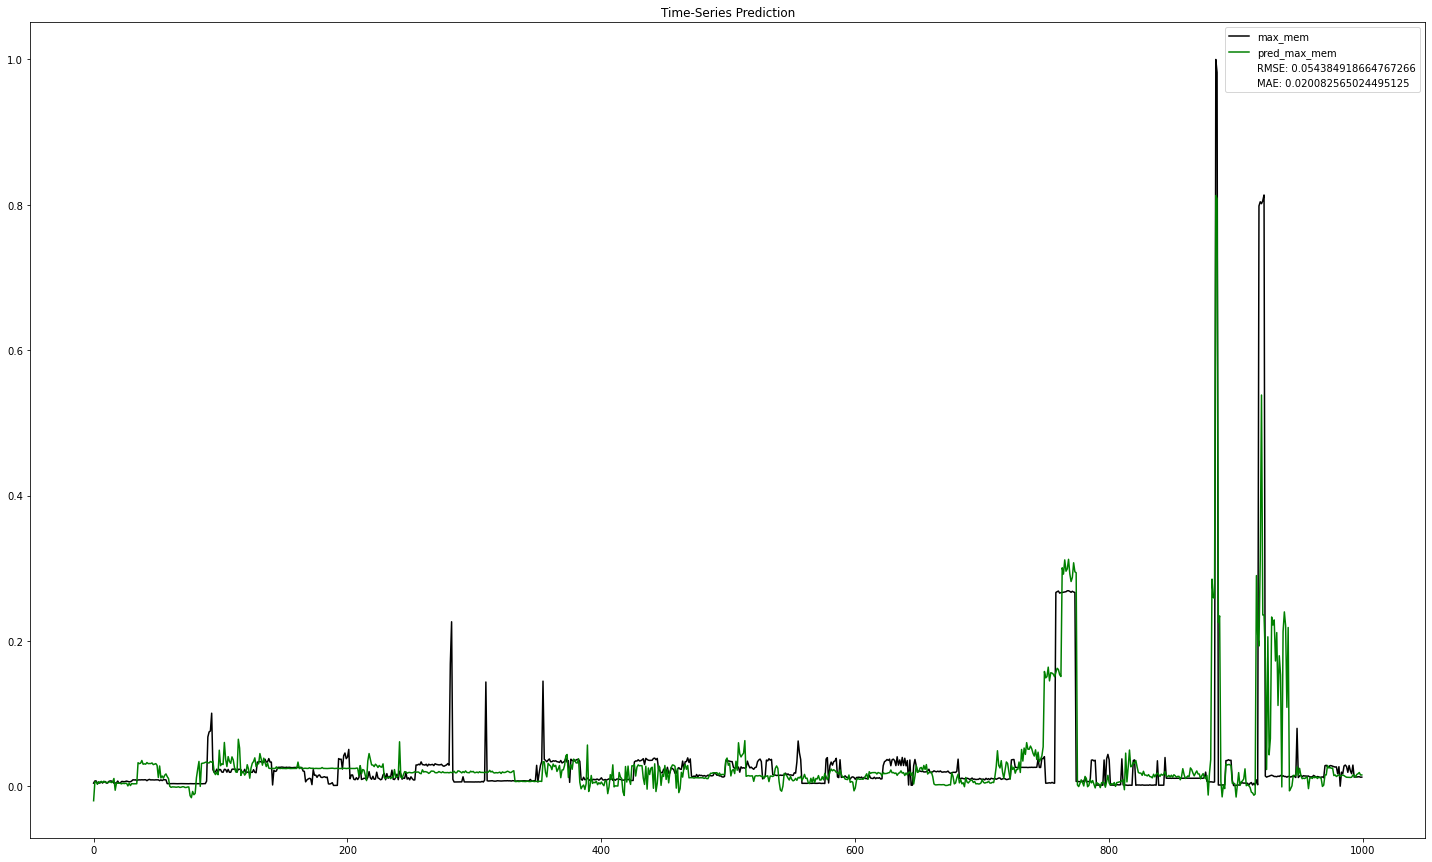

In [30]:
plot_column(column_number=3)

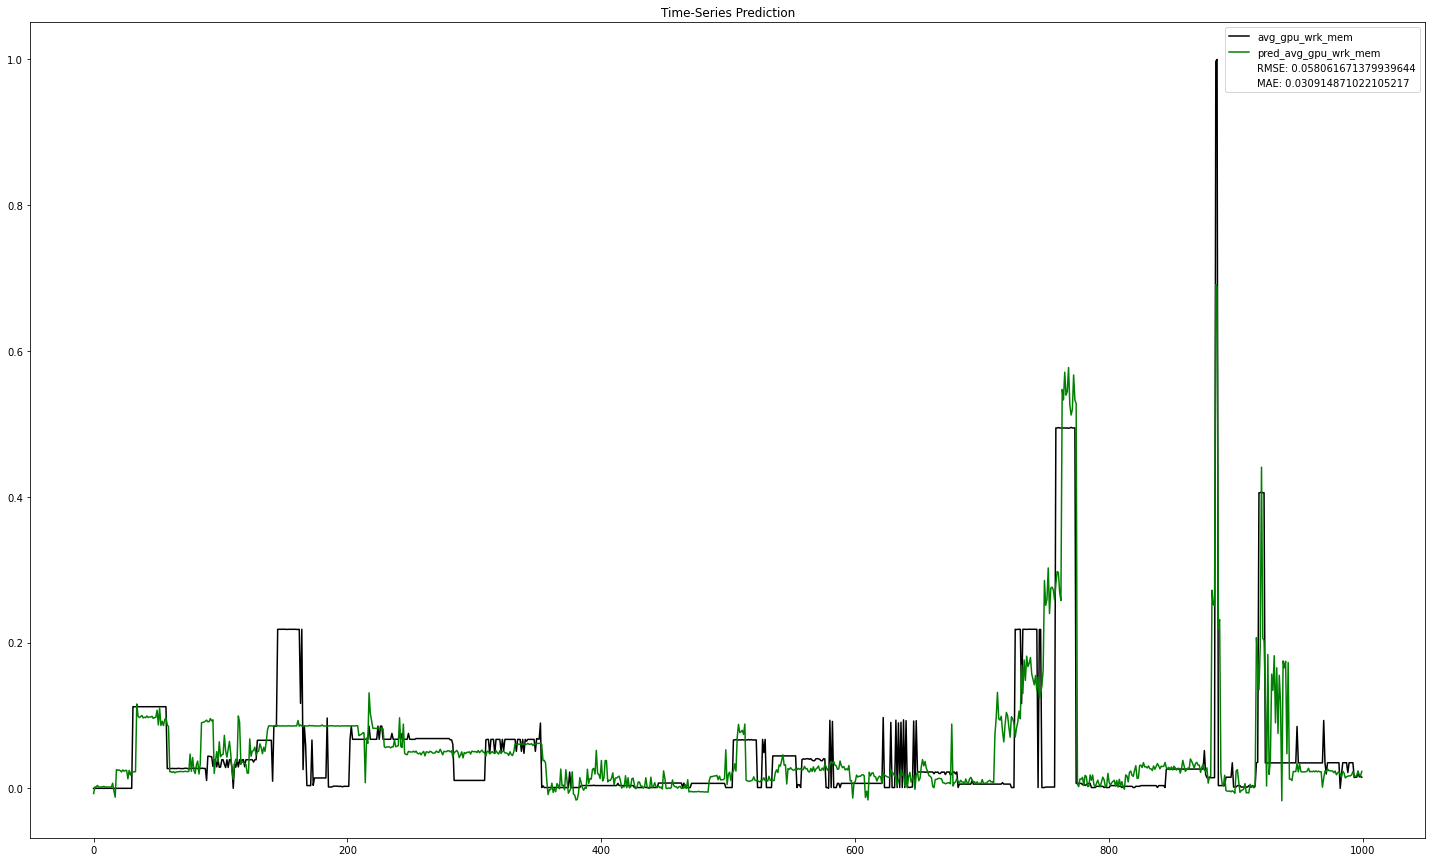

In [31]:
plot_column(column_number=4)

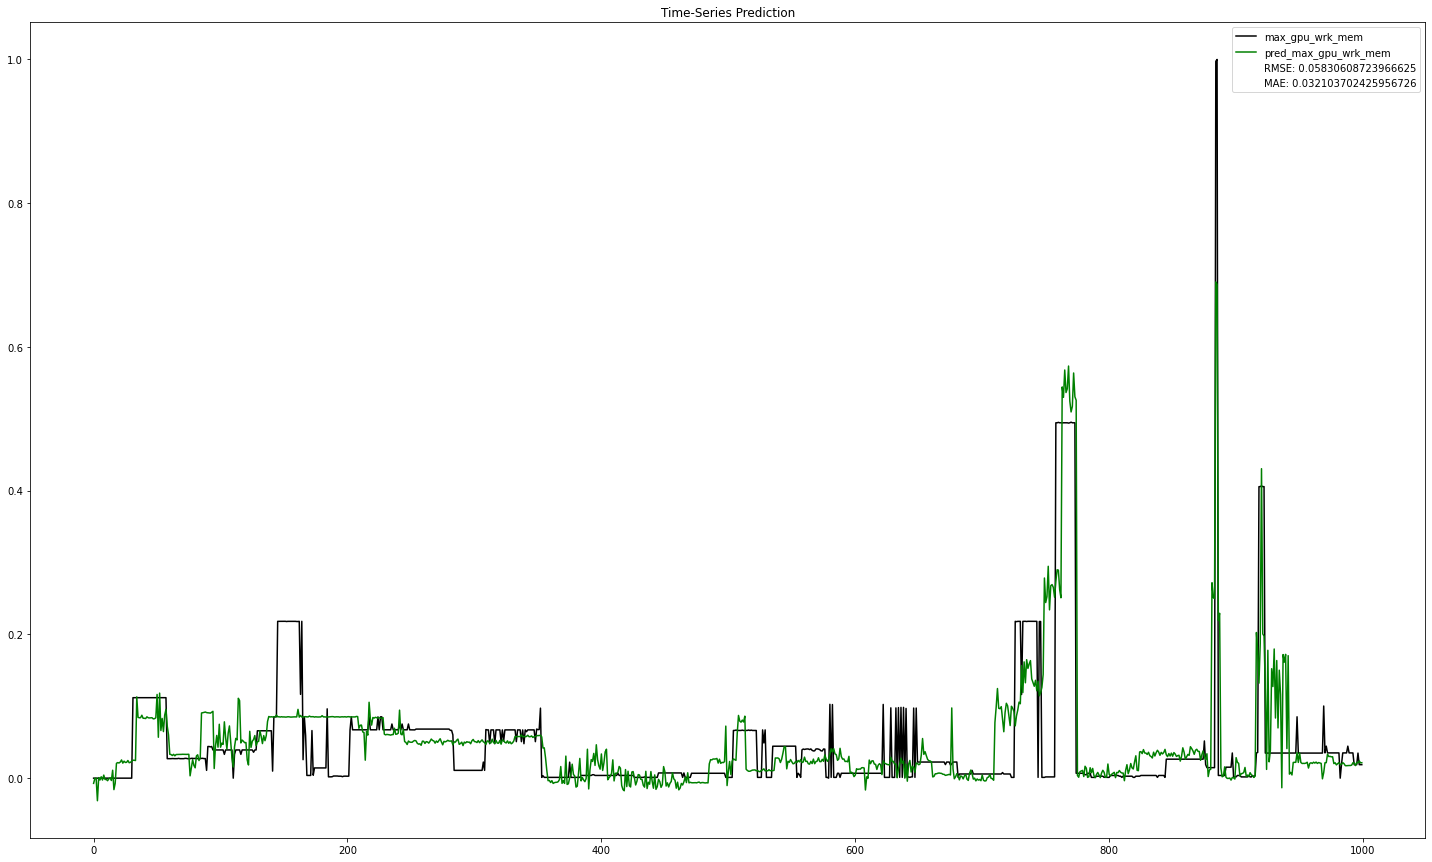

In [32]:
plot_column(column_number=5)

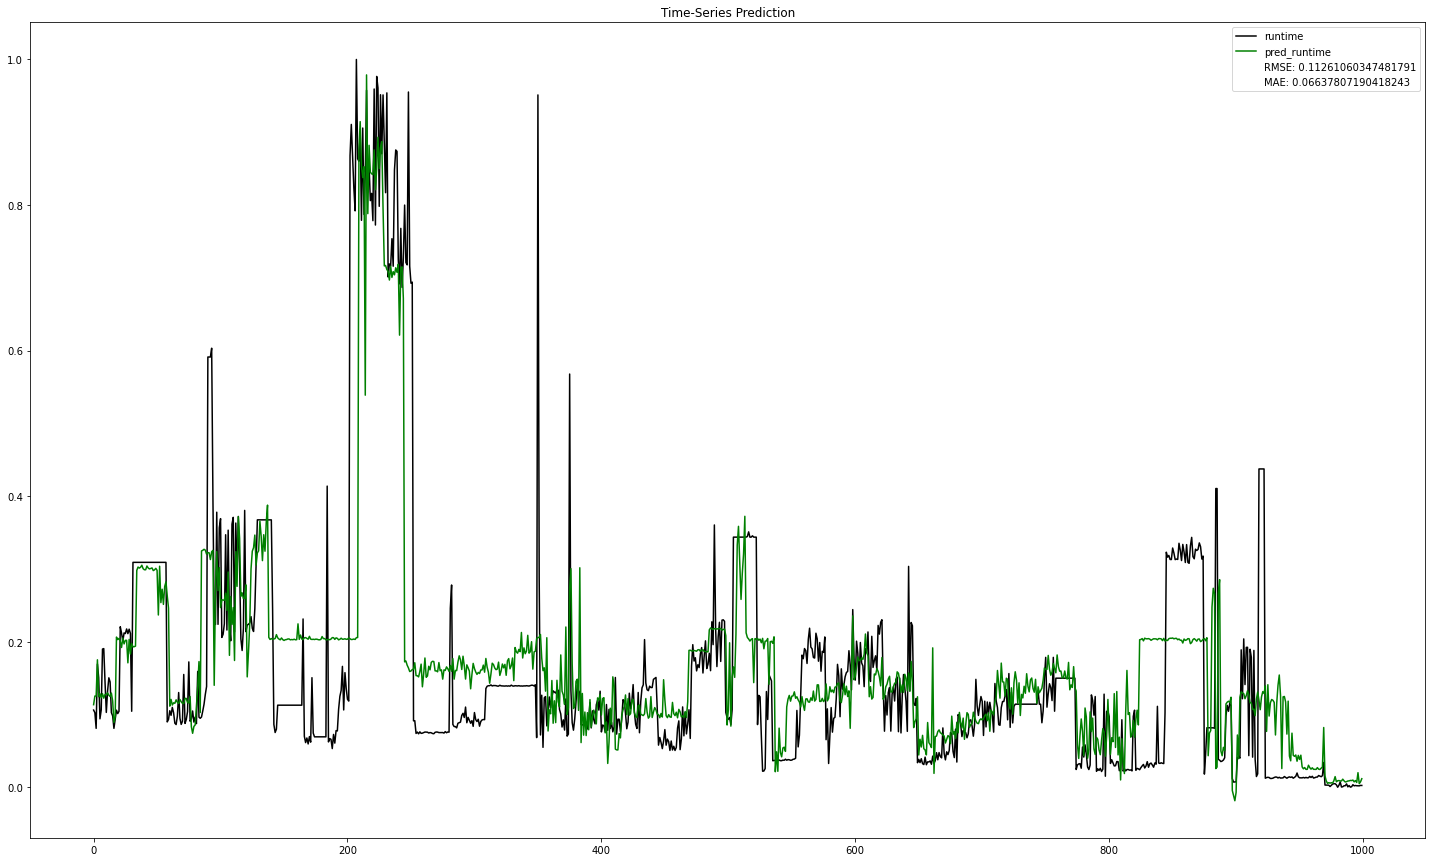

In [33]:
plot_column(column_number=6)